In [315]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [298]:
wwc_outcomes = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/wwc_outcomes.csv"
)
squads = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/squads.csv"
)
codes = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/codes.csv"
)

## Outcomes

In [299]:
outcomes = wwc_outcomes.merge(codes, on='team', how='left')

In [300]:
outcomes_grouped_df = outcomes.groupby(['year', 'yearly_game_id'])

# intermediate column used to calculate opposing_score and difference
outcomes['total_score'] = outcomes_grouped_df['score'].transform(sum)

In [301]:
outcomes['opposing_score'] = outcomes['total_score'] - outcomes['score']
outcomes['won_by'] = outcomes['score'] - outcomes['opposing_score']

# drop intermediate 
outcomes.drop(columns='total_score', inplace=True)

In [302]:
outcomes.head()

,year,team,score,round,yearly_game_id,team_num,win_status,country,opposing_score,won_by
0,1991,CHN,4,Group,1,1,Won,China PR,0,4
1,1991,NOR,0,Group,1,2,Lost,Norway,4,-4
2,1991,DEN,3,Group,2,1,Won,Denmark,0,3
3,1991,NZL,0,Group,2,2,Lost,New Zealand,3,-3
4,1991,JPN,0,Group,3,1,Lost,Japan,1,-1


## WWC outcomes

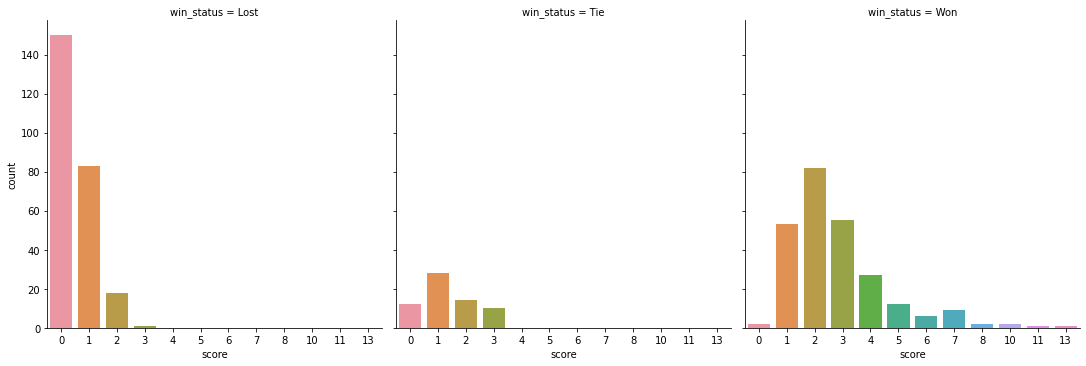

In [303]:
sns.catplot(x ='score', data=outcomes, col ='win_status', 
            kind="count", col_order=["Lost", "Tie", "Won"])
plt.show()

In [304]:
outcomes[outcomes.year == 2019]['round'].value_counts(sort=True)

Group                  72
Round of 16            16
Quarter Final           8
Semi Final              4
Third Place Playoff     2
Final                   2
Name: round, dtype: int64

## Does performance in the group round predict the winner of the finals?

In [305]:
# Of the 3 games each country plays in the "group" round, how much did they win by on average?
avg_group_scores = outcomes[outcomes['round'] == 'Group'].groupby(['year', 'team'], 
                                                                  as_index=False).agg({'score':np.mean, 
                                                                                       'won_by':np.mean})
# rename columns to match markdown
avg_group_scores.rename(columns={'score': 'avg_group_score', 'won_by': 'avg_group_won_by'}, 
                        inplace=True)

In [306]:
avg_group_scores.head()

,year,team,avg_group_score,avg_group_won_by
0,1991,BRA,0.333333,-2.000000
1,1991,CHN,3.333333,2.333333
2,1991,DEN,2.000000,0.666667
3,1991,GER,2.666667,2.666667
4,1991,ITA,2.000000,1.666667


In [307]:
# data needed for below plot
data = outcomes.merge(avg_group_scores, how='inner', on=['year', 'team'])
data = data[data['round'] == 'Final']

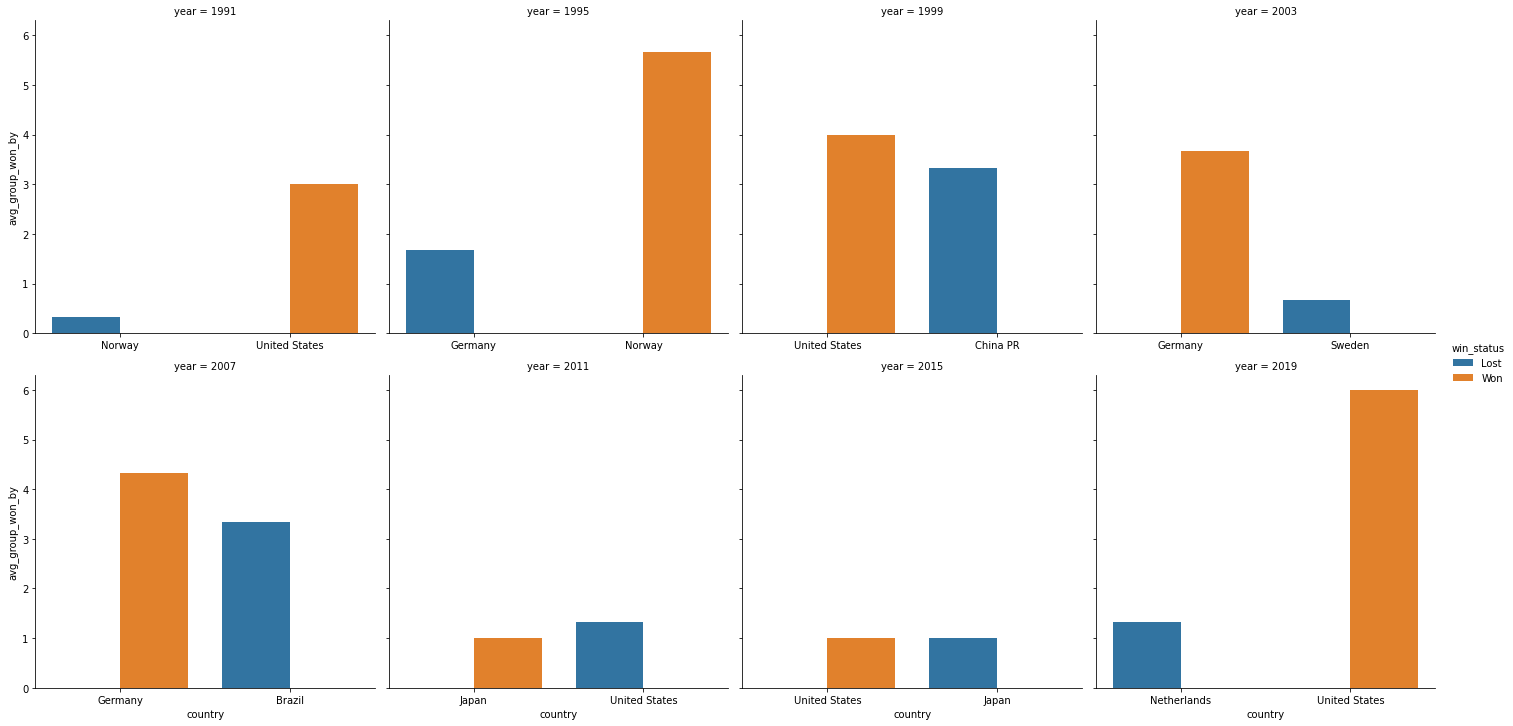

In [308]:
sns.catplot(x='country', y='avg_group_won_by', hue='win_status', 
            data=data, col='year', kind="bar", sharex=False, 
            hue_order=["Lost", "Won"], col_wrap=4)
plt.show()

## Can we use a team's performance in the Group round to predict finals performance?

In [309]:
# data needed for below plot
data = outcomes.merge(avg_group_scores, how='inner', on=['year', 'team'])
data = data[data['round'] != 'Group']

In [310]:
data_group = data.groupby(['year', 'yearly_game_id'])
data['total'] = data_group['avg_group_won_by'].transform(sum)

# *2 allows us to calculate the difference from the total 
# eg avg_won_by = 3, total = 6, thus diff = 3*2 - 6 = 0
data['difference'] = data['avg_group_won_by']*2 - data['total']

data.drop(columns='total', inplace=True)

data=data[data.team_num==2]

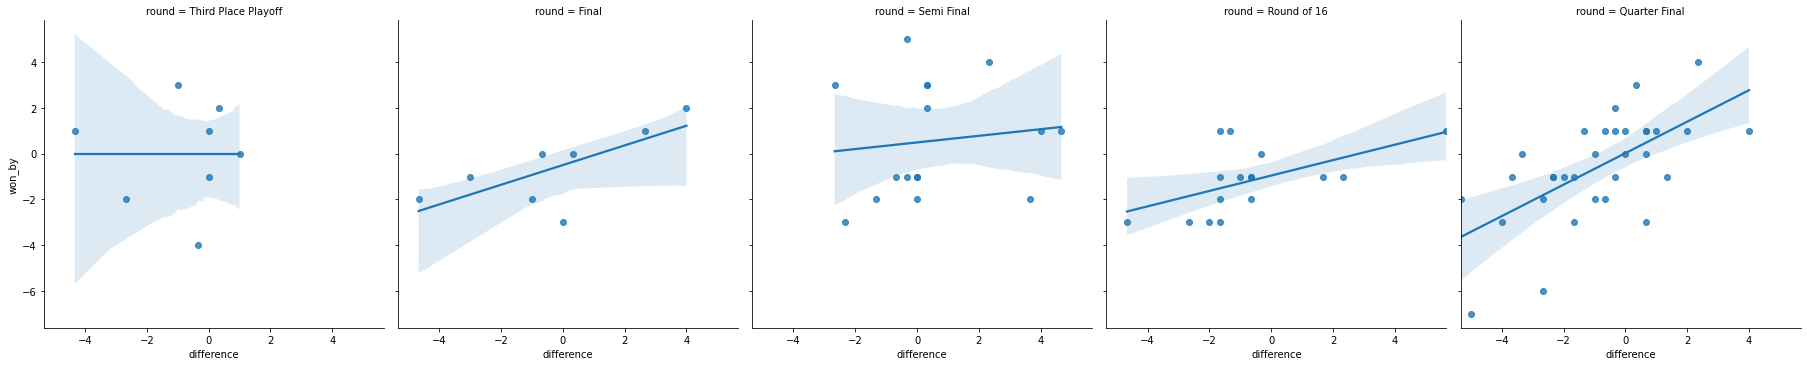

In [311]:
sns.lmplot(x='difference', y='won_by', col='round', data=data,
           col_order=data['round'].value_counts(ascending=True).index)
plt.show()

### Play by play data

Unfortunately package appears to be soley for R. Data is available here: https://github.com/statsbomb/open-data but I dont have to to create a parser for all various events